In [1]:
import pandas as pd
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn

#import matplotlib.pyplot as plt                                                                                                                                              c
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
from statsmodels.graphics.tsaplots import plot_acf
from johansen import Johansen
import itertools

import datetime as dt

#%matplotlib inline
plt.style.use('ggplot')

In [2]:
min_perday=1380

# Data

In [3]:
#import os
#os.chdir("/Users/yuanliu/Box/2018 Fall RCM/1min_data_full_day")
import os
os.chdir('C:\\Users\\lin\\OneDrive\\practium\\23_hour')

In [4]:
#               UTB,       TB,        U10y,      10y,       5y,        2y
bonds =        ['UB',      'ZB',      'TN',       'ZN',     'ZF',      'ZT']
tick_sizes =   [0.03125,   0.03125,   0.015625,   0.015625, 0.0078125, 0.0078125]
point_values = [1000,      1000,      1000,       1000,     1000,      2000]
maturities = ['8H']
maturities_ss = ['H8'] # strategy_studio convention
file_suffix = '.pik'
series_suffix = '_mid'
contract_srt = '2017-12-01'
contract_end = '2018-02-28'

#dont forget set up file path lul


#data_path = '../Data/'+str(mins_per_day)+'/'
#data_path = '../Data/'

assets = [''.join(x) for x in itertools.product(bonds,maturities)]

dfs = []
for a in assets:
    dfs.append(pd.read_pickle(a+file_suffix)[a+series_suffix])
df = pd.concat(dfs, axis=1)

# match different periods
df = df.dropna()
    
# ignore the first and last few days
#df = df.iloc[390*start_ignore:-390*end_engore]
    
# ignore the beginning and end of contract
df['shifted_trading_time'] = df.index.tz_convert('Etc/GMT-2')
df = df[(df['shifted_trading_time'] >= contract_srt) & (df['shifted_trading_time'] < contract_end)]

# drop weekends
df = df[df['shifted_trading_time'].dt.weekday<5]   
df = df.drop('shifted_trading_time',axis=1)

#** for strategy studio
assets = [''.join(x) for x in itertools.product(bonds,maturities_ss)]

# name columns
df.columns = assets

In [5]:
#deal with data issue
df.loc['2018-08-29 17:00:00']['UBU8'] = 158.671875
df.loc['2018-08-29 17:00:00']['ZFU8'] = 113.394531

KeyError: 'the label [2018-08-29 17:00:00] is not in the [index]'

In [ ]:
df.iloc[13800]

In [6]:
train_template = df.copy()
#if len(train_template.loc[train_template.iloc[-1].name.date():]) < min_perday:        # if the last day is not complete
#    last_index = dt.datetime.combine(train_template.iloc[-1].name.date(),dt.time(0,0))-dt.timedelta(minutes=1)
#    train_template = train_template.loc[:last_index]  # take data until the last day   
#if len(train_template.loc[:train_template.iloc[min_perday].name.date()]) < min_perday:       # if the first day is not complete
#    train_template = train_template.loc[train_template.iloc[min_perday].name.date():] # take data from the next day
#train_template.columns = assets
#train_template = train_template.iloc[min_perday*14:-min_perday*14]  # ignore the first and last two weeks
train_template = train_template*point_values
weights = train_template.columns+'_weight'
for w in weights:
    train_template[w] = np.nan
train_template['trading_idx'] = np.nan
train_template['portfolio'] = np.nan
train_template['mu'] = np.nan
train_template['sigma'] = np.nan

In [7]:
len(train_template)/min_perday

63.0

# Parameter

In [8]:
#change our value here!
use_optimized_parameters = False
op_fitting_days = 20
op_exit_threshold = 0
op_increment = 1.75
op_trading_days = 14

In [9]:
from sklearn import linear_model

In [10]:
assets

['UBH8', 'ZBH8', 'TNH8', 'ZNH8', 'ZFH8', 'ZTH8']

In [11]:
#leave this part fixed
def fit(data):
    x = data.values
    x_centered = x - np.mean(x, axis=0)
    johansen = Johansen(x_centered, model=2, significance_level=0)
    eigenvectors, r = johansen.johansen()
    #print('rejected r values are: {}'.format(r))
    vec = eigenvectors[:, 0]
    vec_min = np.min(np.abs(vec))
    vec = vec / vec_min
    #print('The first cointegrating relation: {}'.format(vec))
    return vec 
def fit_1(data):
    temp1=data[assets[5]]
    temp2=data[assets[0:5]]
    reg=linear_model.LinearRegression()
    reg.fit(temp2.values,temp1)
    coint_vec=np.append(-reg.coef_,np.array([1]))
    return coint_vec
    


def apply_strategy(train):
    
    # get thresholds
    round_trip_cost = (np.array(tick_sizes)*np.array(point_values)*abs(train[weights])).sum(axis=1)
    min_increment = round_trip_cost/train['sigma']
    entry_threshold = exit_threshold+min_increment+increment
    train['entry_threshold'] = entry_threshold
    
    train['position'] = np.nan
    train['l_position'] = np.nan
    train['s_position'] = np.nan

    # record position changes
    train['s_position'].loc[train['portfolio'] > (train['mu'] + entry_threshold*train['sigma'])] = -1
    train['s_position'].loc[train['portfolio'] < (train['mu'] + exit_threshold*train['sigma'])] = 0

    train['l_position'].loc[train['portfolio'] < (train['mu'] - entry_threshold*train['sigma'])] = 1
    train['l_position'].loc[train['portfolio'] > (train['mu'] - exit_threshold*train['sigma'])] = 0


    # portfolio is flat at beginning of test period
    train['s_position'].iloc[0] = 0
    train['l_position'].iloc[0] = 0
    # flatten portfolio at end of each trading period
    train['s_position'].loc[train.trading_idx.diff(-1) != 0] = 0
    train['l_position'].loc[train.trading_idx.diff(-1) != 0] = 0
    # flatten portfolio at end
    train['s_position'].iloc[-1] = 0
    train['l_position'].iloc[-1] = 0
    # forward fill positions
    train['s_position'] = train['s_position'].ffill()
    train['l_position'] = train['l_position'].ffill()

    # sum positions
    train['position'] = train['l_position'] + train['s_position']

    # extract trades
    train['trade'] = train['position'].diff(1)
    
    return train


def calc_pnl(round_trips):
    pnls = round_trips[assets]
    # adjust price changes for trade signal
    pnls = pnls.multiply(np.sign(round_trips[weights].values), axis=0)
    pnls = pnls.multiply(-np.sign(round_trips['position']).values, axis=0)
    # account for crossing the spread
    pnls = pnls - np.array(tick_sizes)*np.array(point_values)
    # apply contract weights
    pnls = pnls * np.abs(round_trips[weights].values)
    return pnls

In [12]:
# set parameters:
if use_optimized_parameters:
    fitting_days_range = [op_fitting_days]
    exit_threshold_range = [op_exit_threshold]
    increment_range = [op_increment]
else:
    fitting_days_range = range(5,25,5)
    exit_threshold_range = np.arange(-1,1,0.2)
    increment_range = np.arange(0,4,0.25)

## change stop_sign here!

In [13]:
pnlrecord=[]#record PnL
parameters=[]
stop_sign=1000 # value for stop trading if the 1 dim norm of weights too large, larger than stop_sign
for fitting_days in fitting_days_range:
    if use_optimized_parameters:
        trading_days_range = [op_trading_days]
    else:
        trading_days_range = range(1,fitting_days)
        
    for trading_days in trading_days_range:
        train = train_template.copy()
    
        trade_period = min_perday*trading_days
        fit_period = min_perday*fitting_days
        padding = min_perday*fitting_days
        num_periods = (len(train)-padding)//trade_period
        
    
        # training
        for i in range(num_periods):
            trading_start =  (padding + i     * trade_period)
            trading_end =    (padding + (i+1) * trade_period)
            fitting_start = trading_start-fit_period
            fitting_end =   trading_start
        
            train['trading_idx'].iloc[trading_start:trading_end] = i
            fit_data = train.iloc[fitting_start:fitting_end]
            
            coint_vec = fit(fit_data[assets])
            fit_portfolio = np.dot(fit_data[assets].values, coint_vec)
            #print(coint_vec)
            
            for j in range(len(coint_vec)):
                train[weights[j]][train.trading_idx == i] = coint_vec[j]
            
            train['mu'][train.trading_idx == i] = fit_portfolio.mean()
            train['sigma'][train.trading_idx == i] = fit_portfolio.std()
            train['portfolio'][train.trading_idx == i] = np.dot(train[train.trading_idx == i][assets].values, coint_vec)
            
        train.dropna(subset=['trading_idx'],inplace=True)
        
        # formulate and apply strategy
        for exit_threshold in exit_threshold_range:
            for increment in increment_range:    
                
                apply_strategy(train)
                
                # find trades
                trades = train.loc[train['trade'] != 0].dropna(subset=['trade'])
                trades.reset_index(inplace=True)
                # seperate trades where holding positions jumped
                trades = trades.loc[trades.index.repeat(abs(trades['trade']).astype(int))].reset_index(drop=False)
                
                #if the sum of the abs value of weights(first order norm of weights) outperforms stop_sign, we drop this term 
                trades['temp_value']=np.abs(trades[weights].values).sum(axis=1)
                trades_temp=trades.loc[trades['temp_value']<stop_sign]
                #trades['position'].loc[trades['temp_value']>stop_sign]=0
                #trades_temp=trades.copy()

                # get round trips
                round_trips = trades_temp.iloc[1::2].reset_index() - trades_temp.iloc[::2].reset_index()
                round_trips[weights] = trades_temp[weights].iloc[::2].reset_index(drop=True)
                round_trips=round_trips.dropna()
                #round_trips.drop([round_trips.loc[sum(np.abs(round_trips[weights].values))>stop_sign].index])
                
                pnls = calc_pnl(round_trips)
                
                parameters.append([fitting_days,trading_days,exit_threshold,increment,num_periods])
                result=pnls.sum(axis=1).to_frame('pnl')
                result['holding_period'] = round_trips['timestamp']
                result['trading_total_pos'] = abs(round_trips[weights]).sum(axis=1)
                result['trading_net_pos'] = round_trips[weights].sum(axis=1)
                result['abnormal_close'] = ((trades_temp['position'] == 0) & ((trades_temp['trade']==1)&(trades_temp['portfolio'] - trades_temp['mu'] > trades_temp['sigma']*exit_threshold) | (trades_temp['trade']==-1)&(trades_temp['portfolio'] - trades_temp['mu'] < trades_temp['sigma']*exit_threshold))).iloc[1::2].reset_index(drop=True)
                pnlrecord.append(result)
                          

In [14]:
daily_profit=np.zeros([len(pnlrecord),1])               
for i in range(len(pnlrecord)):
    daily_profit[i]=pnlrecord[i]['pnl'].sum()/parameters[i][1]/parameters[i][4]
maximum=np.max(daily_profit)
idx=daily_profit.argmax()
#[best_parameterfitting_days,trading_days,exit_threshold,op_increment,num_preiods]
best_parameter=parameters[idx]
display(pnlrecord[idx])
print(best_parameter)
print(max(daily_profit))

,pnl,holding_period,trading_total_pos,trading_net_pos,abnormal_close
0,217.826953,3 days 15:18:00,20.780957,-0.484928,False
1,225.995228,2 days 03:57:00,20.780957,-0.484928,False
2,287.588684,2 days 16:15:00,20.780957,-0.484928,False
3,-1170.652746,8 days 07:03:00,32.477048,0.687332,True
4,492.161755,3 days 07:22:00,52.153648,2.078446,False
5,425.124730,4 days 04:25:00,52.153648,2.078446,False
6,501.364199,0 days 15:40:00,52.153648,2.078446,False
7,609.049305,0 days 00:29:00,52.153648,2.078446,False
8,534.545661,0 days 09:16:00,52.153648,2.078446,False
9,-986.868205,2 days 06:34:00,52.153648,2.078446,True


[20, 10, -1.0, 1.5, 4]
[382.21134033]


In [15]:
display(pnlrecord[idx])
daily_profit.sum()

,pnl,holding_period,trading_total_pos,trading_net_pos,abnormal_close
0,217.826953,3 days 15:18:00,20.780957,-0.484928,False
1,225.995228,2 days 03:57:00,20.780957,-0.484928,False
2,287.588684,2 days 16:15:00,20.780957,-0.484928,False
3,-1170.652746,8 days 07:03:00,32.477048,0.687332,True
4,492.161755,3 days 07:22:00,52.153648,2.078446,False
5,425.124730,4 days 04:25:00,52.153648,2.078446,False
6,501.364199,0 days 15:40:00,52.153648,2.078446,False
7,609.049305,0 days 00:29:00,52.153648,2.078446,False
8,534.545661,0 days 09:16:00,52.153648,2.078446,False
9,-986.868205,2 days 06:34:00,52.153648,2.078446,True


-508431.086330293

In [43]:
pnlrecord[idx]['pnl'].sum()

13618.046596687418

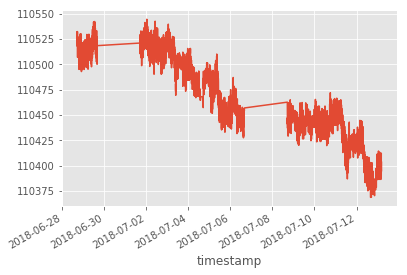

In [33]:
train['portfolio'].iloc[:int(len(train)/4)].plot()

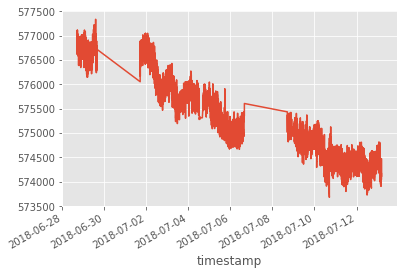

In [38]:
train['portfolio'].iloc[:int(len(train)/4)].plot()

## not sure value plot here

In [15]:
train.loc[train['trade'] != 0].dropna(subset=['trade'])

,UBU8,ZBU8,TNU8,ZNU8,ZFU8,ZTU8,UBU8_weight,ZBU8_weight,TNU8_weight,ZNU8_weight,...,ZTU8_weight,trading_idx,portfolio,mu,sigma,entry_threshold,position,l_position,s_position,trade
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-07-05 09:48:00-05:00,160359.375,145546.875,128414.0625,120320.3125,113605.46875,211757.8125,-1.000000,-1.546695,19.333344,-26.702348,...,3.096483,0.0,5.750097e+05,5.764495e+05,274.663897,5.093891,1.0,1.0,0.0,1.0
2018-07-18 15:59:00-05:00,159484.375,144796.875,128039.0625,120070.3125,113441.40625,211539.0625,-1.000000,-1.546695,19.333344,-26.702348,...,3.096483,0.0,5.742983e+05,5.764495e+05,274.663897,5.093891,0.0,0.0,0.0,-1.0
2018-07-20 09:00:00-05:00,159109.375,144703.125,128039.0625,120148.4375,113542.96875,211617.1875,-11.016619,64.975138,-276.168724,282.208755,...,1.000000,1.0,4.678827e+06,4.660488e+06,3723.395229,4.767127,-1.0,0.0,-1.0,-1.0
2018-07-24 23:06:00-05:00,157453.125,143453.125,127398.4375,119664.0625,113261.71875,211492.1875,-11.016619,64.975138,-276.168724,282.208755,...,1.000000,1.0,4.660237e+06,4.660488e+06,3723.395229,4.767127,0.0,0.0,0.0,1.0
2018-07-31 15:01:00-05:00,156921.875,143015.625,127132.8125,119414.0625,113105.46875,211351.5625,-11.016619,64.975138,-276.168724,282.208755,...,1.000000,1.0,4.642706e+06,4.660488e+06,3723.395229,4.767127,1.0,1.0,0.0,1.0
2018-08-01 17:00:00-05:00,155609.375,142187.500,126679.6875,119171.8750,113015.62500,211328.1250,-11.016619,64.975138,-276.168724,282.208755,...,1.000000,1.0,4.661494e+06,4.660488e+06,3723.395229,4.767127,0.0,0.0,0.0,-1.0
2018-08-10 09:48:00-05:00,158109.375,144046.875,127929.6875,120148.4375,113566.40625,211648.4375,-1.943495,3.321928,6.632650,-14.962739,...,-1.000000,2.0,-8.790485e+04,-8.699082e+04,147.200981,5.687685,1.0,1.0,0.0,1.0
2018-08-13 14:24:00-05:00,158078.125,144328.125,128054.6875,120242.1875,113628.90625,211648.4375,-1.943495,3.321928,6.632650,-14.962739,...,-1.000000,2.0,-8.698723e+04,-8.699082e+04,147.200981,5.687685,0.0,0.0,0.0,-1.0


In [16]:
trades

,index,timestamp,UBU8,ZBU8,TNU8,ZNU8,ZFU8,ZTU8,UBU8_weight,ZBU8_weight,...,trading_idx,portfolio,mu,sigma,entry_threshold,position,l_position,s_position,trade,temp_value
0,0,2018-07-05 09:48:00-05:00,160359.375,145546.875,128414.0625,120320.3125,113605.46875,211757.8125,-1.000000,-1.546695,...,0.0,5.750097e+05,5.764495e+05,274.663897,5.093891,1.0,1.0,0.0,1.0,60.788844
1,1,2018-07-18 15:59:00-05:00,159484.375,144796.875,128039.0625,120070.3125,113441.40625,211539.0625,-1.000000,-1.546695,...,0.0,5.742983e+05,5.764495e+05,274.663897,5.093891,0.0,0.0,0.0,-1.0,60.788844
2,2,2018-07-20 09:00:00-05:00,159109.375,144703.125,128039.0625,120148.4375,113542.96875,211617.1875,-11.016619,64.975138,...,1.0,4.678827e+06,4.660488e+06,3723.395229,4.767127,-1.0,0.0,-1.0,-1.0,650.593469
3,3,2018-07-24 23:06:00-05:00,157453.125,143453.125,127398.4375,119664.0625,113261.71875,211492.1875,-11.016619,64.975138,...,1.0,4.660237e+06,4.660488e+06,3723.395229,4.767127,0.0,0.0,0.0,1.0,650.593469
4,4,2018-07-31 15:01:00-05:00,156921.875,143015.625,127132.8125,119414.0625,113105.46875,211351.5625,-11.016619,64.975138,...,1.0,4.642706e+06,4.660488e+06,3723.395229,4.767127,1.0,1.0,0.0,1.0,650.593469
5,5,2018-08-01 17:00:00-05:00,155609.375,142187.500,126679.6875,119171.8750,113015.62500,211328.1250,-11.016619,64.975138,...,1.0,4.661494e+06,4.660488e+06,3723.395229,4.767127,0.0,0.0,0.0,-1.0,650.593469
6,6,2018-08-10 09:48:00-05:00,158109.375,144046.875,127929.6875,120148.4375,113566.40625,211648.4375,-1.943495,3.321928,...,2.0,-8.790485e+04,-8.699082e+04,147.200981,5.687685,1.0,1.0,0.0,1.0,35.801116
7,7,2018-08-13 14:24:00-05:00,158078.125,144328.125,128054.6875,120242.1875,113628.90625,211648.4375,-1.943495,3.321928,...,2.0,-8.698723e+04,-8.699082e+04,147.200981,5.687685,0.0,0.0,0.0,-1.0,35.801116


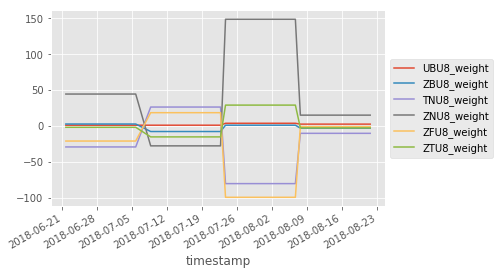

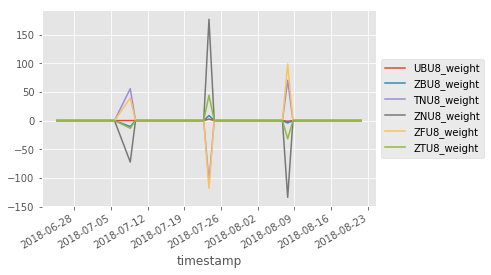

In [15]:
adjusted_weights = train[weights].multiply(np.sign(train[weights].iloc[:,0].values),axis=0)
weights_daily = adjusted_weights.iloc[::1380,]
weights_daily.plot()
plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
weights_daily.diff().plot()
plt.legend(loc='center left',bbox_to_anchor=(1,0.5))

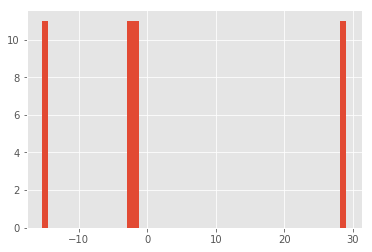

2.2602422244148426
16.53647275111247


In [16]:
iter_column = 5
plt.hist(weights_daily.iloc[:,iter_column],bins=50)
plt.show()
print(weights_daily.iloc[:,iter_column].mean())
print(weights_daily.iloc[:,iter_column].std())

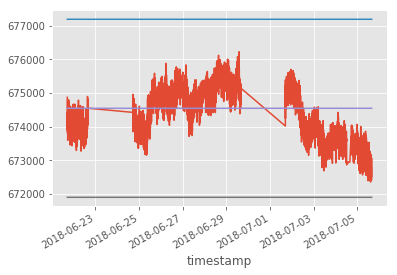

In [17]:
s_t = min_perday*0
e_t = min_perday*10
train['portfolio'].iloc[s_t:e_t].plot()
plt.plot((train.mu+train['entry_threshold']*train.sigma).iloc[s_t:e_t])
plt.plot((train.mu).iloc[s_t:e_t])
plt.plot((train.mu-train['entry_threshold']*train.sigma).iloc[s_t:e_t])

In [24]:
#display(train)

###### import pandas as pd
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn

import matplotlib.pyplot as plt

import statsmodels.tsa.stattools as ts          
from statsmodels.graphics.tsaplots import plot_acf
from johansen import Johansen
import itertools

import datetime as dt

#%matplotlib inline
plt.style.use('ggplot')

In [19]:
assets[0]

'UBU8'

# output the parameter txt

In [31]:
os.chdir('C:\\Users\\lin\\OneDrive\\practium\\1000')

In [32]:
iterator_temp=1
for row in train[::min_perday].iterrows():
    #print(row[1].name)
    date = (row[1].name.date())+dt.timedelta(days=1)
    print(date)
    with open('{}.txt'.format(date),'w') as file:
        file.write('signal_mean={}\n'.format(row[1]['mu']))
        file.write('signal_standard_deviation={}\n'.format(row[1]['sigma']))
        file.write('entry_threshold={}\n'.format(row[1]['entry_threshold']))
        file.write('exit_threshold={}\n'.format(op_exit_threshold))
        file.write('abnormal_close={}\n'.format(int(iterator_temp%op_trading_days==0)))
        row_weights = row[1][weights]
        for i in range(len(row_weights)):
            file.write('{}={}\n'.format(assets[i],row_weights[i]))
    iterator_temp+=1

2018-06-29
2018-07-02
2018-07-03
2018-07-04
2018-07-05
2018-07-06
2018-07-09
2018-07-10
2018-07-11
2018-07-12
2018-07-13
2018-07-16
2018-07-17
2018-07-18
2018-07-19
2018-07-20
2018-07-23
2018-07-24
2018-07-25
2018-07-26
2018-07-27
2018-07-30
2018-07-31
2018-08-01
2018-08-02
2018-08-03
2018-08-06
2018-08-07
2018-08-08
2018-08-09
2018-08-10
2018-08-13
2018-08-14
2018-08-15
2018-08-16
2018-08-17
2018-08-20
2018-08-21
2018-08-22
2018-08-23
2018-08-24
2018-08-27


In [33]:
iterator_temp

43

In [17]:
train.iloc[-1]

UBU8               1.586875e+05
ZBU8               1.448281e+05
TNU8               1.282344e+05
ZNU8               1.203359e+05
ZFU8               1.135938e+05
ZTU8               2.116328e+05
UBU8_weight       -1.000000e+00
ZBU8_weight       -1.625340e+01
TNU8_weight       -1.619393e+01
ZNU8_weight        1.551266e+02
ZFU8_weight       -2.077989e+02
ZTU8_weight        8.361113e+01
trading_idx        7.000000e+00
portfolio          8.168255e+06
mu                 8.161786e+06
sigma              1.251169e+03
entry_threshold    8.662129e+00
position           0.000000e+00
l_position         0.000000e+00
s_position         0.000000e+00
trade              0.000000e+00
Name: 2018-08-31 15:59:00-05:00, dtype: float64